In [2]:
!pip install pygame pyvirtualdisplay

In [3]:
!apt install swig && pip install gymnasium box2d box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (6,293 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import base64
import os

In [5]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


In [6]:
env.observation_space.shape

(2,)

In [7]:
obs_space_low_ar = env.observation_space.low
obs_space_high_ar = env.observation_space.high
arrays = []
for i in range(len(obs_space_low_ar)):
    arrays.append([obs_space_low_ar[i], obs_space_high_ar[i]])
obs_bounds = np.array(arrays)
print(obs_bounds)


[[-1.2   0.6 ]
 [-0.07  0.07]]


In [8]:
class TileCoder:
    def __init__(self, num_tilings, tiles_per_dim, state_bounds, num_actions):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.state_bounds = state_bounds
        self.num_actions = num_actions

        self.tile_width = (self.state_bounds[:, 1] - self.state_bounds[:, 0]) / (tiles_per_dim - 1)
        self.offsets = [np.linspace(0, self.tile_width[d], num_tilings) for d in range(len(state_bounds))]

        self.total_tiles = (tiles_per_dim ** len(state_bounds)) * num_tilings * num_actions

    def get_features(self, state, action):
        """
        Return binary feature vector for given state and action
        """
        features = np.zeros(self.total_tiles)
        for tiling in range(self.num_tilings):
            coords = []
            for i in range(len(state)):
                offset = self.offsets[i][tiling]
                coord = int((state[i] - self.state_bounds[i][0] + offset) / self.tile_width[i])
                coords.append(coord)

            flat_index = self._tile_index(tiling, coords, action)
            features[flat_index] = 1

        return features.reshape(-1)

    def _tile_index(self, tiling, coords, action):
        """
        Compute flattened index in the feature vector
        """
        index = 0
        for c in coords:
            index = index * self.tiles_per_dim + c
        index += tiling * (self.tiles_per_dim ** len(coords))
        index += action * self.num_tilings * (self.tiles_per_dim ** len(coords))
        return index


In [9]:
tile_coder = TileCoder(num_tilings=8, tiles_per_dim=4, state_bounds=obs_bounds, num_actions=env.action_space.n)

The action space is discrete with actions taking on values of 0 or 1 or 2. The observation space is a continuous but bounded space in R^2.  This notebook is an implementation of a function approximation version SARSA. I chose to replicate the function and feature creation choices made in Sutton & Barto's book. Specifically, the feature creation is done at the state, action level with tile coding. The function being learned is a linear function.

In [11]:
alpha = .01
gamma = .99 #discount factor on future rewards
num_episodes = 15000
epsilon = .05
dim = tile_coder.total_tiles
wts = np.random.normal(size=dim)
num_actions = env.action_space.n

def gradient_descent_step(w, r, s, a, s_, a_, is_done):
  if not is_done:
    features = tile_coder.get_features(s, a)
    next_features = tile_coder.get_features(s_, a_)
    w += alpha * (r + gamma * np.dot(w, next_features) - np.dot(w, features)) * features
  else:
    features = tile_coder.get_features(s, a)
    w += alpha * (r - np.dot(w, features)) * features
  return w

def get_greedy_action(w, s):
  action_values = np.zeros(num_actions)
  for i in range(num_actions):
    features = tile_coder.get_features(s, i)
    action_values[i] = np.dot(w, features)
  return np.argmax(action_values)


In [12]:
for episode_idx in range(num_episodes):
  reward_sum = 0
  next_obs, _ = env.reset() #reset the env to get initial state

  #choose actionin an epsilon greedy manner
  if np.random.random() <= epsilon:
      next_action = env.action_space.sample()
  else:
      next_action = get_greedy_action(wts, next_obs)


  done = False
  while not done:
      action = next_action
      obs = next_obs
      next_obs, reward, terminated, truncated, _ = env.step(action)
      reward_sum += reward
      if np.random.random() <= epsilon:
        next_action = env.action_space.sample()
      else:
        next_action = get_greedy_action(wts, next_obs)
      done = terminated or truncated

      wts = gradient_descent_step(wts, reward, obs, action, next_obs, next_action, done)
      if done:
        if episode_idx % 100 == 0:
          print(episode_idx, reward_sum, sep=': ')


env.close()


0: -200.0
100: -150.0
200: -143.0
300: -146.0
400: -140.0
500: -200.0
600: -140.0
700: -162.0
800: -151.0
900: -150.0
1000: -193.0
1100: -192.0
1200: -200.0
1300: -154.0
1400: -136.0
1500: -137.0
1600: -144.0
1700: -146.0
1800: -189.0
1900: -161.0
2000: -145.0
2100: -146.0
2200: -138.0
2300: -200.0
2400: -200.0
2500: -158.0
2600: -141.0
2700: -152.0
2800: -153.0
2900: -200.0
3000: -142.0
3100: -144.0
3200: -146.0
3300: -134.0
3400: -145.0
3500: -151.0
3600: -146.0
3700: -200.0
3800: -149.0
3900: -135.0
4000: -200.0
4100: -139.0
4200: -107.0
4300: -191.0
4400: -146.0
4500: -139.0
4600: -153.0
4700: -146.0
4800: -147.0
4900: -145.0
5000: -144.0
5100: -186.0
5200: -138.0
5300: -137.0
5400: -144.0
5500: -142.0
5600: -200.0
5700: -151.0
5800: -154.0
5900: -145.0
6000: -146.0
6100: -136.0
6200: -138.0
6300: -200.0
6400: -155.0
6500: -144.0
6600: -116.0
6700: -138.0
6800: -171.0
6900: -130.0
7000: -179.0
7100: -149.0
7200: -195.0
7300: -148.0
7400: -148.0
7500: -142.0
7600: -137.0
7700: -200.

-127.0


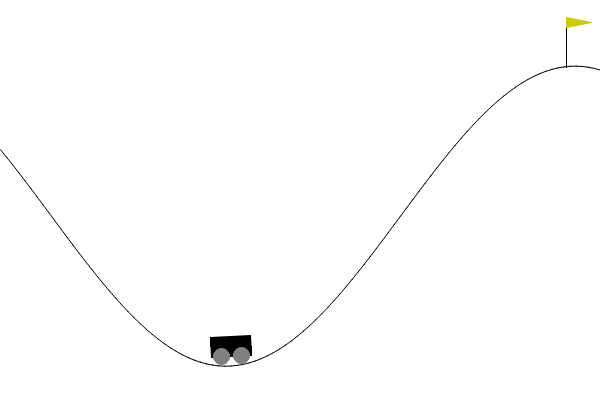

In [13]:
reward_sum = 0
next_obs, _ = env.reset() #reset the env to get initial state
next_action = get_greedy_action(wts, next_obs)

frames = []

done = False
while not done:
    frame = env.render()
    frames.append(Image.fromarray(frame))
    action = next_action
    obs = next_obs
    next_obs, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    next_action = get_greedy_action(wts, next_obs)
    done = terminated or truncated

env.close()
print(reward_sum)
# Save to GIF
frames[0].save("mountain_car.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

# Display the GIF in notebook
from IPython.display import Image as IPyImage
IPyImage(filename="mountain_car.gif")